# MCMC using backward filtering, forward guiding for shapes with SDE transitions

Parameter inference for trees with Brownian flows (Kunita flows) transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebooks [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb), [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb), [mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb](mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb) for simplified versions. The covariance of each stochastic step is shape dependent and the processes nonlinear, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from examples.SDE import dts, dot, solve, forward
from examples.ABFFG import *
from examples.shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# seed,
#seed = 42
import os; seed = int(os.urandom(5).hex(), 16)
print("seed: ",seed)
key = PRNGKey(seed)

seed:  371566139202


# Shape related setup

<Axes: >

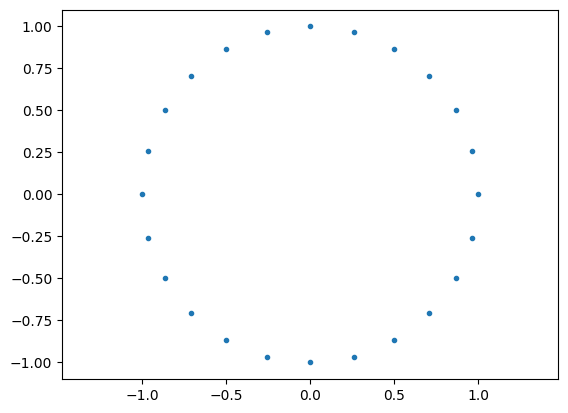

In [4]:
# define shape and plot
d = 2; n = 24 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape = plot_shape_2d
plot_shape(root)

# SDE setup

In [5]:
n_steps = 100 # number of time steps in the discretization

 # drift
def b(t,x,params): return jnp.zeros(n*d)

# diffusion and covariance specification for shape processes
# assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix
kQ12 = lambda x,params: (.25/max(16,n))*k_K2(x,params)
#kQ12 = lambda x,params: (.4/max(16,n))*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
#sigma = lambda q,theta: kQ12_q(root,root,theta) # diffusion field, kernel evaluated on all landmark pairs
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance

# Tree with SDE transitions

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
#degree = 2; topology = symmetric_topology(height=3, degree=degree)
degree = 2; topology = symmetric_topology(height=4, degree=degree)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)
n_leaves = tree.is_leaf.sum()


# add properties to tree
tree.add_property('edge_length', shape=())
n_edges = tree.data['edge_length'].shape[0]
# data dimension
d = 2
tree.add_property('value', shape=(n_steps+1,n*d,))
tree.add_property('noise', shape=(n_steps,n*d))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                                     None
                  ┌───────────────────┴───────────────────┐
                 None                                    None                  
        ┌─────────┴─────────┐                   ┌─────────┴─────────┐          
       None                None                None                None        
   ┌────┴────┐         ┌────┴────┐         ┌────┴────┐         ┌────┴────┐     
  None      None      None      None      None      None      None      None   
 ┌─┴──┐    ┌─┴──┐    ┌─┴──┐    ┌─┴──┐    ┌─┴──┐    ┌─┴──┐    ┌─┴──┐    ┌─┴──┐  
None None None None None None None None None None None None None None None None
HypTree(size=31, levels=5, leaves=16, inner nodes=14)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.3), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions using the SDE functions above. The step covariance is square of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps); _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs = forward(parent_value.reshape((-1,n*d))[-1],_dts,_dWs,b,sigma,params)
        return {'value': Xs}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
# sample new noise
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# add noise to leaf nodes
key, subkey = split(key)
leaf_values = tree.data['value'][tree.is_leaf,-1]+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,tree.data['value'][tree.is_leaf,-1].shape)

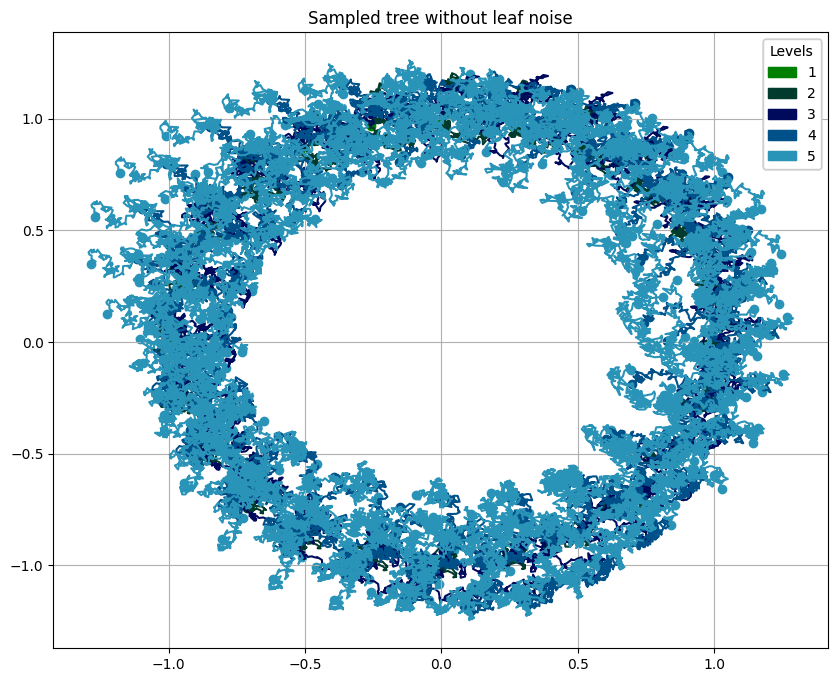

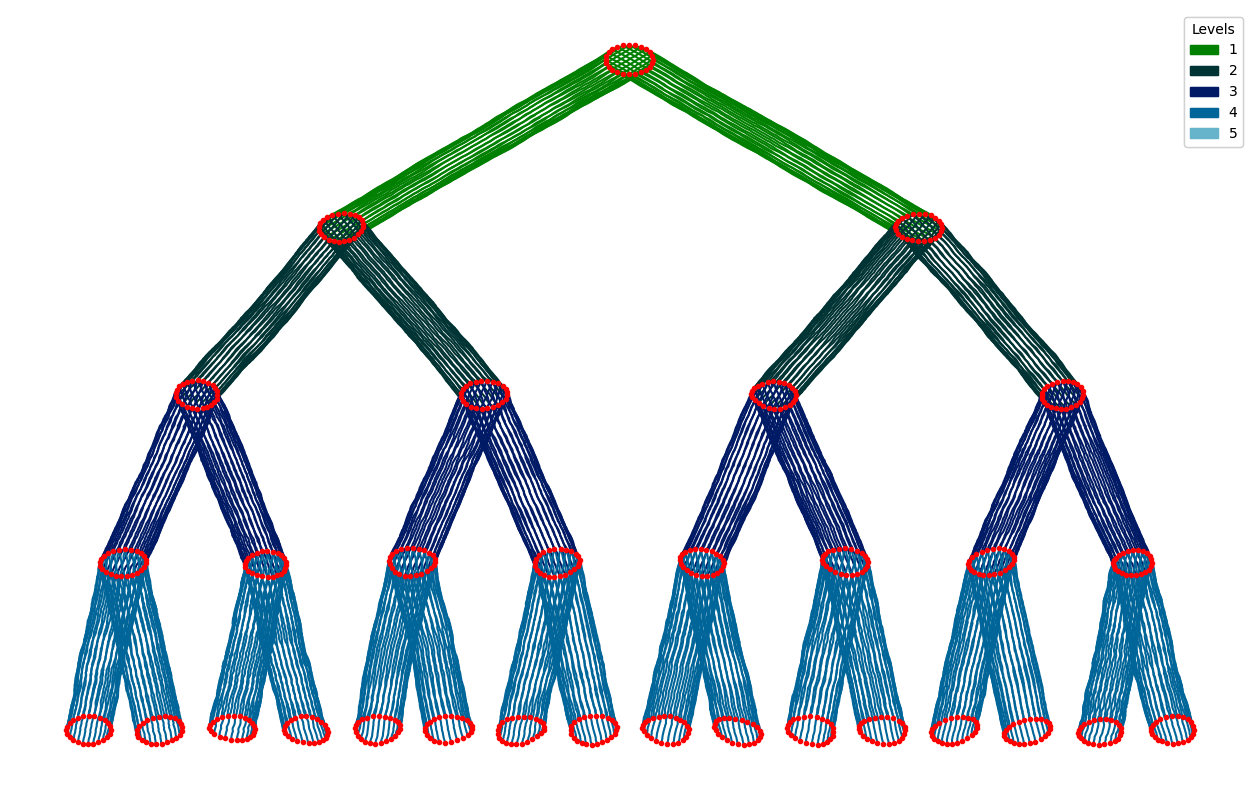

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
@jax.jit
def up(noise,edge_length,v_0,v_T,F_T,H_T,params,**args):
    def f(edge_length,v_0,v_T,F_T,H_T):
        var = edge_length # variance is edge length
        T = var # running time of Brownian motion
        tildea0 = a(v_0,params); tildeaT = a(v_T,params)

        _ts = jnp.cumsum(jnp.concatenate((jnp.array([0.]), dts(T=T,n_steps=n_steps))))[:-1]
        #Phi_inv = lambda t:  jnp.eye(n)+H_T@tildea*(T-t)
        Phi_inv = lambda t:  jnp.eye(n)+H_T@((-(t**2-T**2)/(2*T))*tildeaT+((T-t)**2/(2*T))*tildea0)
        H_0 = solve(Phi_inv(0),H_T).reshape(H_T.shape)
        F_0 = solve(Phi_inv(0),F_T).reshape(F_T.shape)
        #v_T = solve(H_T,F_T)
        
        c_0 = jax.vmap(lambda v_T: logphi_H(jnp.zeros(n),v_T,H_0),1)(v_T.reshape((n,d)))
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(edge_length,v_0,v_T,F_T,H_T)
def transform(child_c_0,child_F_0,child_H_0,params,**args):
    F_T = child_F_0
    H_T = child_H_0
    c_T = child_c_0
    v_T = jax.vmap(lambda H,F: solve(H,F))(H_T,F_T)
    return {'c_T': c_T, 'v_T': v_T, 'F_T': F_T, 'H_T': H_T}
upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'c_0': 'sum',
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree for up
tree.add_property('c_0', shape=(d,)); tree.add_property('v_0', shape=(n*d,)); tree.add_property('F_0', shape=(n*d,)); tree.add_property('H_0', shape=(n,n)); tree.add_property('c_T', shape=(d,)); tree.add_property('v_T', shape=(n*d,)); tree.add_property('F_T', shape=(n*d,)); tree.add_property('H_T', shape=(n,n)); tree.add_property('logpsi')
# initialize v_0,v_T
tree.data['v_0'] = tree.data['v_0'].at[:].set(root); tree.data['v_T'] = tree.data['v_T'].at[:].set(root)
def init_up(leaf_values,params,v_T=None):
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(n)/params['obs_var'].value)[None,:,:])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jax.vmap(lambda H,v: dot(H,v))(tree.data['H_T'][tree.is_leaf],leaf_values))
    Sigma = params['obs_var'].value*jnp.eye(n)
    tree.data['v_T'] = tree.data['v_T'].at[tree.is_leaf].set(leaf_values)
    tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(jax.vmap(lambda v: jax.vmap(lambda v: logphi(jnp.zeros(n),v,Sigma),1)(v.reshape((n,d))))(leaf_values))
    # update v_0 from parent v_T
    if v_T is not None:
        tree.data['v_0'] = v_T[tree.parents]
        tree.data['v_0'] = tree.data['v_0'].at[tree.is_root].set(root)

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
@jax.jit
def down_conditional(noise,edge_length,v_0,v_T,F_T,H_T,parent_value,params,**args):
    def f(noise,edge_length,v_0,v_T,F_T,H_T,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps)
        _dWs = jnp.sqrt(_dts)[:,None]*noise
        tildea0 = a(v_0,params); tildeaT = a(v_T,params)
        Xs,logpsi = forward_guided(parent_value.reshape((-1,n*d))[-1],H_T,F_T,tildea0,tildeaT,_dts,_dWs,b,sigma,params)
        return {'value': Xs, 'logpsi': logpsi}

    return jax.vmap(f)(noise,edge_length,v_0,v_T,F_T,H_T,parent_value)
downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding
init_up(leaf_values,params)
up.up(tree,params.values())
down_conditional.down(tree,params.values())

# time the operations
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())
%time down_unconditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time down_conditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time up.up(tree,params.values()); jax.block_until_ready(tree.data['H_0'])
None

CPU times: user 4.49 ms, sys: 965 μs, total: 5.45 ms
Wall time: 4.39 ms
CPU times: user 141 ms, sys: 17.9 ms, total: 158 ms
Wall time: 134 ms
CPU times: user 2.4 ms, sys: 642 μs, total: 3.05 ms
Wall time: 2.31 ms


# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.4, 'k_sigma': 0.6, 'obs_var': 0.0005}
data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.5, 'obs_var': 0.001}


100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Acceptance rate: 0.2540


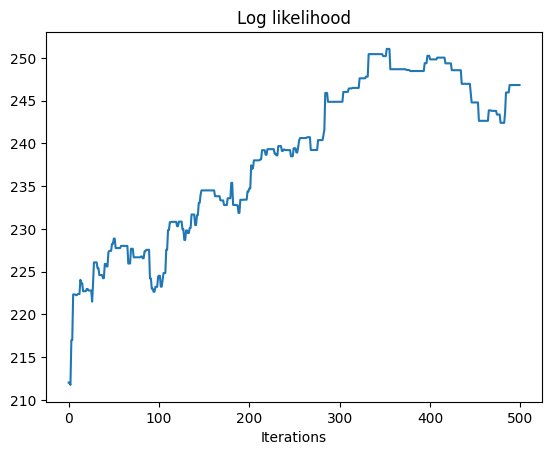

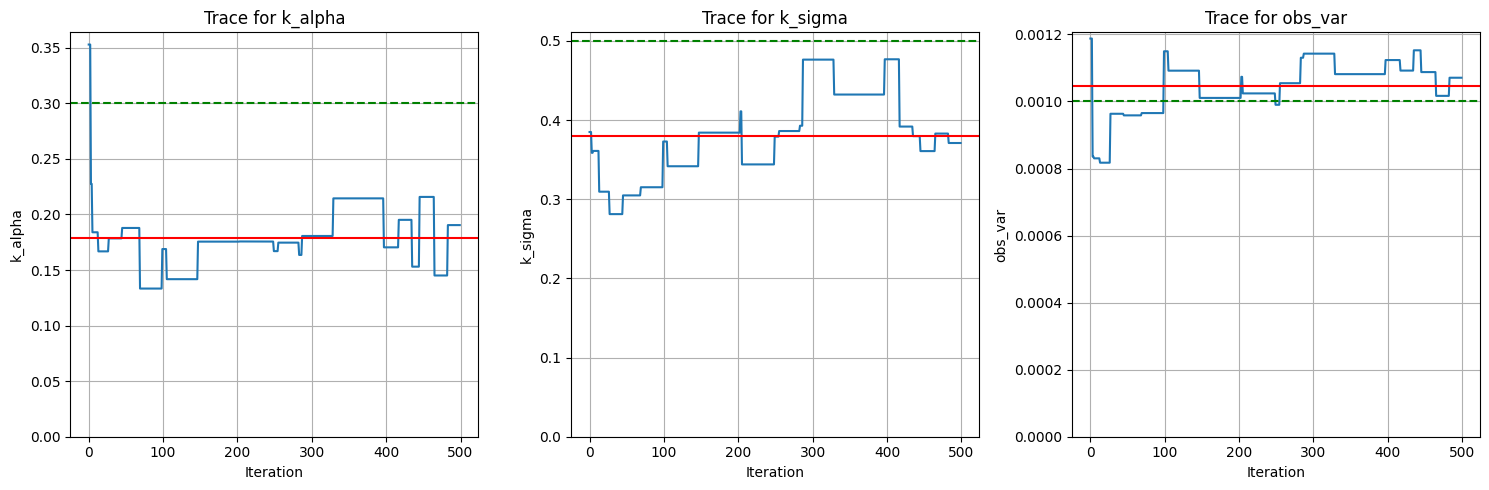

In [16]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# log likelihood of the tree under the Gaussian approximation with correction factors
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,(noise,v_T) = state
    # backwards filtering with current parameters
    init_up(data,params,v_T); up.up(tree,params.values())
    v,c,F,H = tree.data['value'][tree.is_root][:,0],tree.data['c_T'][tree.is_root],tree.data['F_T'][tree.is_root],tree.data['H_T'][tree.is_root]
    v = jnp.squeeze(v); c = jnp.squeeze(c); F = jnp.squeeze(F); H = jnp.squeeze(H)
    tree_log_likelihood = c.sum()+F@v-.5*v.T@dot(H,v)
    # forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    tree_logpsi = jnp.sum(tree.data['logpsi'])
    return tree_log_likelihood+tree_logpsi

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = sum([v.log_prior() for k,v in parameters.params.items() if k!='obs_var'])
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,(noise,v_T) = state
    
    # Use static variable to alternate between parameter and noise updates
    if not hasattr(proposal, 'update_params'):
        proposal.update_params = True
    
    if proposal.update_params:
        #new_parameters,log_correction = parameters.propose(subkeys[1])
        ## update all parameters except obs_var
        subkeys = jax.random.split(subkeys[1],len(parameters.params))
        proposals_and_corrections = {k: v.propose(rngkey) for rngkey,(k,v) in zip(subkeys,parameters.params.items()) if k!='obs_var'}
        new_params = {k: v[0] for k,v in proposals_and_corrections.items()}
        log_correction = sum(v[1] for v in proposals_and_corrections.values())
        # obs_var
        residuals = tree.data['value'][tree.is_leaf][:,-1]-data
        alpha_post = init_params['obs_var'].alpha+.5*residuals.size # alpha from prior
        beta_post = init_params['obs_var'].beta+.5*jnp.sum(residuals**2) # beta from prior
        new_obs_var = beta_post/jax.random.gamma(subkeys[-1],alpha_post) # inverse gamma sample
        new_params['obs_var'] = VarianceParameter(**{**params['obs_var'].__dict__,'value':new_obs_var})
        new_parameters = ParameterStore(new_params)
        new_state = new_parameters,(noise,tree.data['v_T'])
    else:
        new_noise = update_CN(noise,subkeys[1])
        new_state = parameters,(new_noise,v_T)
        log_correction = 0.
        
    proposal.update_params = not proposal.update_params
    return new_state,log_correction

# tree values and parameters
init_params = ParameterStore({
    #'k_alpha': VarianceParameter(.3,alpha=1.,beta=.6), # kernel amplitude, governs global tree variance
    'k_alpha': VarianceParameter(.4,min=0.,max=1.,proposal='mirrored_gaussian',prior='uniform'), # kernel amplitude, governs global tree variance
    #'k_sigma': VarianceParameter(.5,alpha=1.,beta=1.,max=1.), # kernel width, for Gaussian kernels this is proportional to the variance
    'k_sigma': VarianceParameter(.6,min=1e-7,max=1.,proposal='mirrored_gaussian',prior='uniform'), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(.5*1e-3,alpha=2,beta=.003) # observation noise varianc
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,(jnp.zeros_like(tree.data['noise']),tree.data['v_T']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 500, burn_in=000, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,params.values())

In [17]:
## plot internal data
## Plot level by level from leaves up (excluding root)
#for level_num, level in enumerate(tree.levels[1:]):  # Skip root level
#    print(f"Level {level_num+1}")
#    for i in range(*level):
#        print(tree.data['logpsi'][i])
#        ax = plot_shape(tree.data['v_0'][i],color='blue',label='v_0')
#        plot_shape(tree.data['v_T'][i],color='red',label='v_T',ax=ax)
#        ax.set_aspect('auto')
#        ax.axis([-1.5,1.5,-1.5,1.5])
#        plt.legend()
#        plt.show()

/Users/stefan/projects/hyperiax/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57616 instead
  warnings.warn(


Number of workers: 10
Cores per worker: {'tcp://127.0.0.1:57642': 2, 'tcp://127.0.0.1:57645': 2, 'tcp://127.0.0.1:57646': 2, 'tcp://127.0.0.1:57647': 2, 'tcp://127.0.0.1:57648': 2, 'tcp://127.0.0.1:57655': 2, 'tcp://127.0.0.1:57658': 2, 'tcp://127.0.0.1:57659': 2, 'tcp://127.0.0.1:57664': 2, 'tcp://127.0.0.1:57667': 2}
k_alpha - mean: 0.2518, median: 0.2418
k_sigma - mean: 0.4596, median: 0.4712
obs_var - mean: 0.0011, median: 0.0011


2025-03-04 13:07:17,030 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-03-04 13:07:17,031 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-03-04 13:07:17,032 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-03-04 13:07:17,032 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


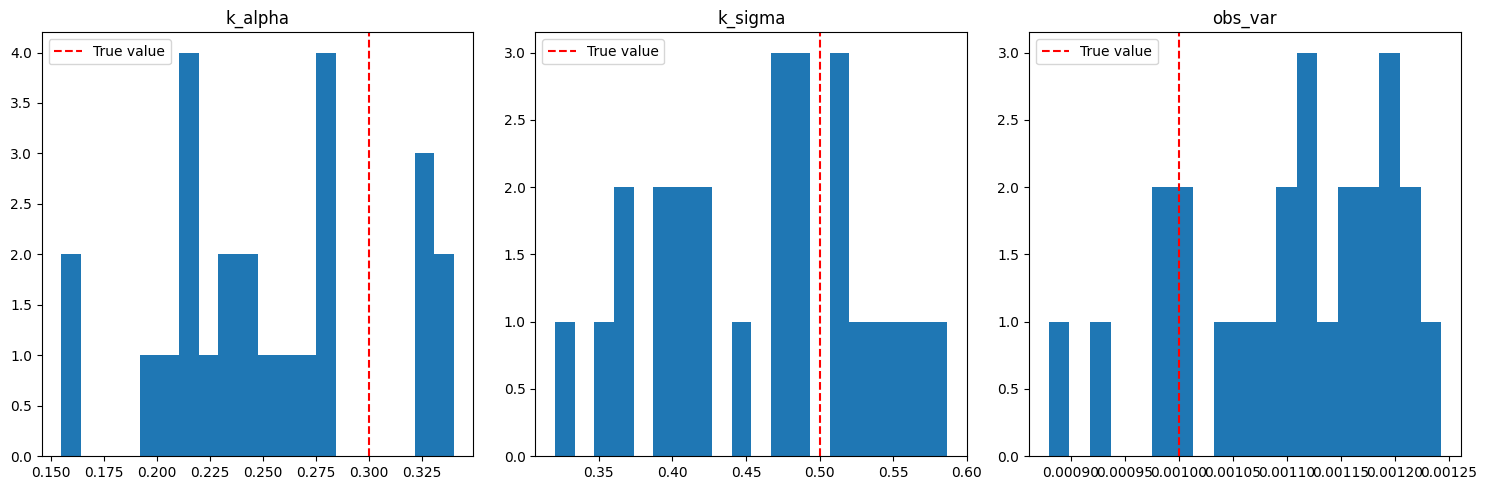

In [18]:
import dask
from dask.distributed import Client, LocalCluster

# Set up dask client for parallel processing
# Using 10 workers as a balanced choice for M3
cluster = LocalCluster(n_workers=10)  # Use 10 workers to mainly utilize P cores
client = Client(cluster)
# Get number of workers and threads
print(f"Number of workers: {len(client.ncores())}")
print(f"Cores per worker: {client.ncores()}")

# Number of parallel chains
K = 25

# Function to run single MCMC chain
def run_mcmc_chain(seed):
    key = jax.random.PRNGKey(seed)

    # sample leaf values
    subkey, key = split(key)
    update_noise(tree,subkey)
    down_unconditional.down(tree,params.values())

    # add noise to leaf nodes
    key, subkey = split(key)
    leaf_values = tree.data['value'][tree.is_leaf,-1]+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,tree.data['value'][tree.is_leaf,-1].shape)

    # mcmc
    subkey, key = split(key)
    init_state = (init_params,(jnp.zeros_like(tree.data['noise']),tree.data['v_T']))
    log_likes, chain_samples = metropolis_hastings(log_posterior, proposal, leaf_values, 
                                                 init_state, 500, burn_in=2000, 
                                                 rng_key=key, savef=lambda state: state[0],
                                                 verbose=False)
    # Get mean of samples for each parameter
    means = {k: jnp.mean(jnp.array([s[k].value for s in chain_samples])) for k in chain_samples[0].values().keys()}
    return means

# Run chains in parallel
futures = [dask.delayed(run_mcmc_chain)(i) for i in range(K)]
results = dask.compute(*futures)

# Convert results to parameter arrays
k_alpha_means = jnp.array([r['k_alpha'] for r in results])
k_sigma_means = jnp.array([r['k_sigma'] for r in results])
obs_var_means = jnp.array([r['obs_var'] for r in results])

print(f"k_alpha - mean: {jnp.mean(k_alpha_means):.4f}, median: {jnp.median(k_alpha_means):.4f}")
print(f"k_sigma - mean: {jnp.mean(k_sigma_means):.4f}, median: {jnp.median(k_sigma_means):.4f}")
print(f"obs_var - mean: {jnp.mean(obs_var_means):.4f}, median: {jnp.median(obs_var_means):.4f}")

# Plot histograms
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

ax1.hist(k_alpha_means,bins=20)
ax1.axvline(params['k_alpha'].value,color='r',linestyle='--',label='True value')
ax1.set_title('k_alpha')
ax1.legend()

ax2.hist(k_sigma_means,bins=20)
ax2.axvline(params['k_sigma'].value,color='r',linestyle='--',label='True value')
ax2.set_title('k_sigma')
ax2.legend()

ax3.hist(obs_var_means,bins=jnp.linspace(min(obs_var_means),max(obs_var_means),20))
ax3.axvline(params['obs_var'].value,color='r',linestyle='--',label='True value')
ax3.set_title('obs_var')
ax3.legend()

plt.tight_layout()

# Clean up dask client
client.close()
cluster.close()


Prior is maximized at x = 0.001
Prior is maximized at x = 0.001
Prior is maximized at x = 0.001002020202020202


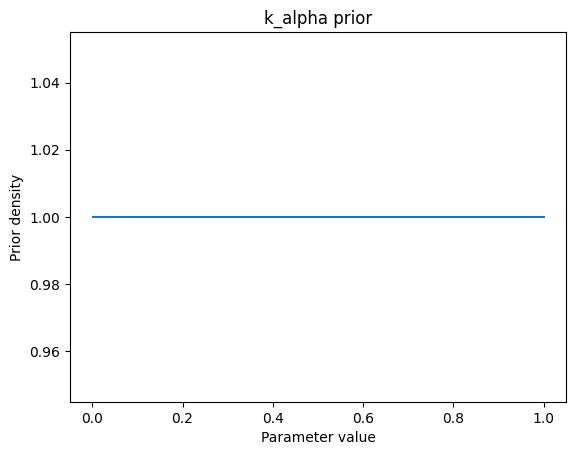

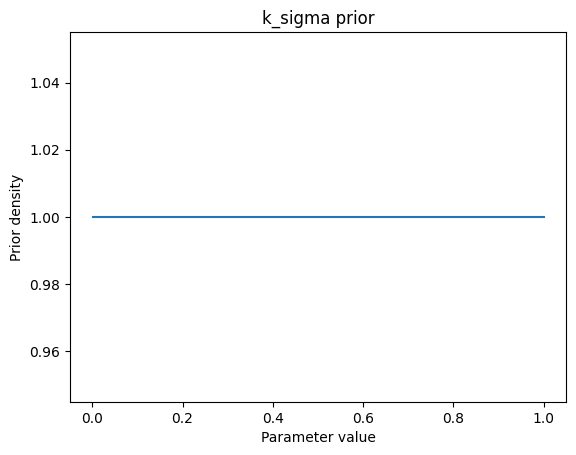

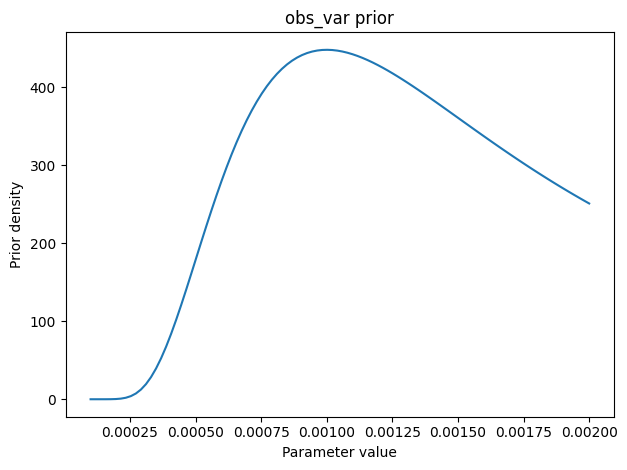

In [19]:
# Plot priors for all initial parameters
init_params['k_alpha'].plot_prior()
plt.title('k_alpha prior')

init_params['k_sigma'].plot_prior()
plt.title('k_sigma prior')

init_params['obs_var'].plot_prior(x_min=1e-4,x_max=2*1e-3)
plt.title('obs_var prior')

plt.tight_layout()
